# EVAC Examination

In [596]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, DataLoader
import math



## Data Exploration

In [597]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math


In [598]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 7
numHiddenNodes1 = 16
numHiddenNodes2 = 32
numOutputNodes = 1

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) + (numHiddenNodes1 * numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes) + numHiddenNodes1 + numHiddenNodes2 + numOutputNodes

/var/folders/01/z8y87srs6v7g5h7dy9fw6_kr0000gn/T/ipykernel_21504/829615054.py:1: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now()) # Set a random seed from the clock


In [599]:
all_data = pd.read_csv('eScooterDemand.csv')
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


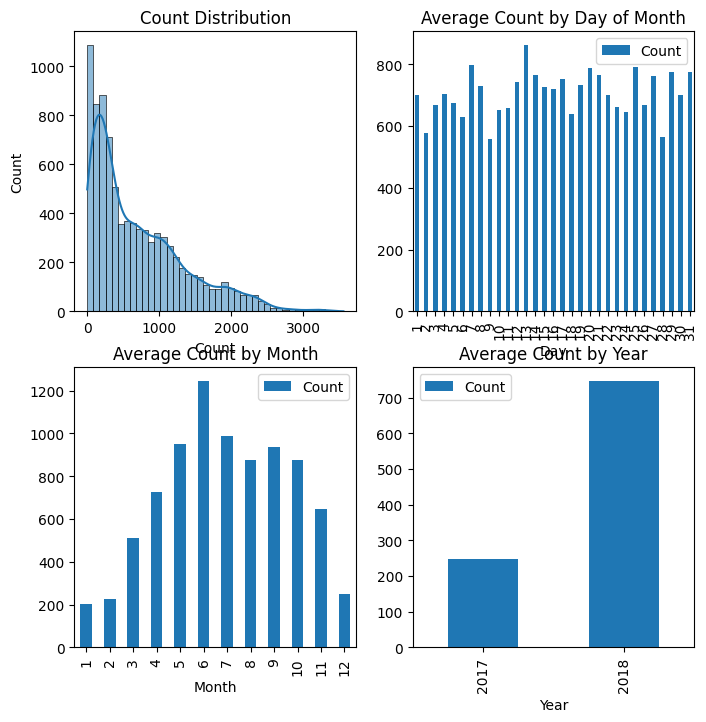

In [600]:


## plot average count over time to look for patterns that can be used to predict future demand
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%d/%m/%Y')
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year
all_data['Day'] = all_data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(all_data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
all_data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
all_data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
all_data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')

plt.show()


In [601]:
all_data.query("HireAvailable=='No'").head()


,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day
3144,2018-04-11,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3145,2018-04-11,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3146,2018-04-11,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3147,2018-04-11,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No,No,4,2018,11
3148,2018-04-11,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No,No,4,2018,11


## Set up representation

In [602]:
!pip install deap

In [603]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator
from IPython import display


In [604]:
## Prepare data for training
all_data['Windspeed'] = all_data['Wind speed']
all_data['HireAvailable'] = all_data['HireAvailable'].map({'Yes': 1, 'No': 0})
all_data['PublicHoliday'] = all_data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
all_data['Weekend'] = all_data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
all_data['Season'] = all_data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [605]:
all_data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [606]:
x = torch.linspace(-math.pi, math.pi, 2000, dtype=torch.float)
print(x)

tensor([-3.1416, -3.1384, -3.1353,  ...,  3.1353,  3.1384,  3.1416])


In [607]:
from torch import nn


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(7, 16)  # 8 input neurons, 16 neurons in hidden layer
        self.fc2 = nn.Linear(16, 32)  # 16 neurons in hidden layer, 1 output neuron
        self.fc4 = nn.Linear(32, 1)  # 16 neurons in hidden layer, 1 output neuron

    def set_weights(self, weights):
        self.fc1.weight.data = torch.tensor(weights[0:112]).reshape(16, 7)
        self.fc1.bias.data = torch.tensor(weights[112:128])
        self.fc2.weight.data = torch.tensor(weights[128:640]).reshape(32, 16)
        self.fc2.bias.data = torch.tensor(weights[640:672])
        self.fc4.weight.data = torch.tensor(weights[672:704]).reshape(1, 32)
        self.fc4.bias.data = torch.tensor(weights[704:705])


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc4(x)
        return x

    def get_weights(self):

        
        x = [self.fc1.weight.data, self.fc1.bias.data, self.fc2.weight.data, self.fc2.bias.data, self.fc4.weight.data, self.fc4.bias.data]

        weights = []
        for i in x:
            weights.extend(i.flatten().tolist())
        return weights



In [608]:
nen = MLP()
nen.forward(torch.linspace(-math.pi, math.pi, 7, dtype=torch.float))
print(torch.linspace(-math.pi, math.pi, 7, dtype=torch.float).shape)

nen.get_weights()

torch.Size([7])


[0.13603530824184418,
 0.12261998653411865,
 0.27276909351348877,
 -0.05114910751581192,
 -0.11711714416742325,
 0.20747466385364532,
 0.22727295756340027,
 0.3245631456375122,
 0.05981723591685295,
 0.05336387827992439,
 -0.2905091643333435,
 0.17666305601596832,
 -0.03424182906746864,
 -0.23919735848903656,
 0.34837985038757324,
 -0.018679408356547356,
 0.0786336213350296,
 -0.3113357126712799,
 0.12510213255882263,
 -0.17436924576759338,
 0.30333560705184937,
 0.2628706395626068,
 0.11242645978927612,
 -0.1398019790649414,
 -0.27206867933273315,
 0.10514301061630249,
 -0.15383656322956085,
 -0.04997942969202995,
 -0.09340907633304596,
 -0.3575551509857178,
 0.16261444985866547,
 0.19403932988643646,
 0.06622882932424545,
 0.04402277618646622,
 0.15416431427001953,
 -0.09083393961191177,
 0.27401405572891235,
 0.37310948967933655,
 0.24281208217144012,
 -0.1771877408027649,
 0.3484712839126587,
 0.18106907606124878,
 -0.2430156171321869,
 0.09885329753160477,
 -0.005263634491711855,


In [609]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 2.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [610]:
import numpy
# randomise data
all_data = all_data.sample(frac=1).reset_index(drop=True)
test_data = all_data.sample(frac=0.2)
train_data = all_data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print(test_data.size)

print(train_data.size)
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


35040
140160


In [611]:

## Mean absolute error: On some regression problems, the distribution of the target variable may be mostly Gaussian, but may have outliers, e.g. large or small values far from the mean value.

def eval(individual, myNet, evdata):
  # myNet.set_weights(individual)
  fitness = 0
  for i in range(len(evdata)):
    myNet.set_weights(individual)
    
    input = [evdata['PublicHoliday'][i], evdata['Weekend'][i], evdata['Month'][i], evdata['Hour'][i], evdata['Temp'][i], evdata['Windspeed'][i], evdata['Visibility'][i]]
    output = myNet.forward(torch.tensor(input, dtype=torch.float))
    
    
    fitness += abs(evdata['Count'][i] - output[0])
  return fitness/len(evdata),




In [612]:
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)
type(x)

numpy.ndarray

In [613]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.4)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

myNet = MLP()


baseline = toolbox.evaluate(myNet.get_weights(), myNet, train_data)


In [614]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [615]:
## SANITYY CHECK
ind = toolbox.individual()

# ind.fitness.values = toolbox.evaluate(ind, myNet, train_data)
print(len(ind))
print(myNet.set_weights(ind))
print(toolbox.evaluate(ind, myNet, train_data))

721
None
(tensor(94334.9922, grad_fn=<DivBackward0>),)


In [616]:
logbook = tools.Logbook()
hof = tools.HallOfFame(1)
pop = toolbox.population(n=100)

In [617]:
fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

KeyboardInterrupt: 

In [ ]:
NGEN = 250

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

    gen = [g] * 100
    hof.update(pop)



-- Generation 0 --


KeyboardInterrupt: 

In [ ]:
print(logbook)


IndexError: list index out of range

[4.796518190206602, -0.541733763189753, -0.7607875927234383, 0.5268756999450759, -2.1117613764653846, -1.4251768044945705, -4.860945442485777, 5.678576087455616, -7.431983627417858, 4.232522845077704, 2.102909501053527, -0.8947901670540898, 2.4909851350311674, -8.708915424748328, -3.8676286617130327, 2.2838265186286106, -0.3048233301035653, 8.60498466084237, -1.088605913065753, -9.974462323158056, -1.9288767818802963, -11.527258881883311, -4.203830250734825, 0.5716373332219201, -1.5717914834101414, 8.5643660613386, -2.7160410135790514, 3.8988780571260158, 2.5112160262432424, -1.8666533526667244, -2.595553883651868, -1.6863917255124903, 8.416953867371111, -6.0000513765131895, 7.631461407509111, -5.715611680526951, 2.6139051846290884, -0.9454705580238609, -5.3567144707486225, 7.029626970259824, 3.866946394431598, 4.078431438405009, 4.978766454860929, -1.0296459841315642, -1.6083770326824118, 7.23117836788719, -3.644036436152307, -3.8906217973127273, 3.697530602684716, -0.553724963659004,

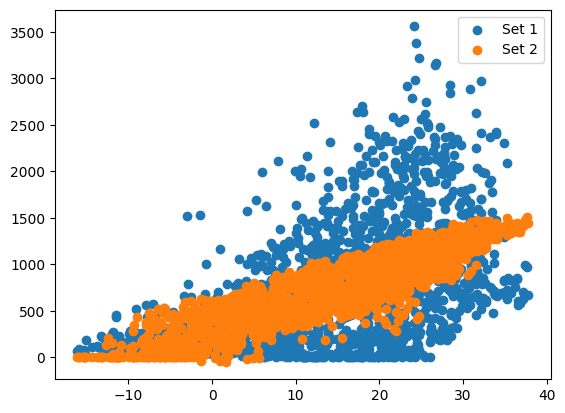

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = tools.selBest(pop, 1)[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
print(toolbox.evaluate(best_ind, myNet, test_data))
myNet.setWeightsLinear(best_ind)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i]] for i in range(len(test_data))]

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

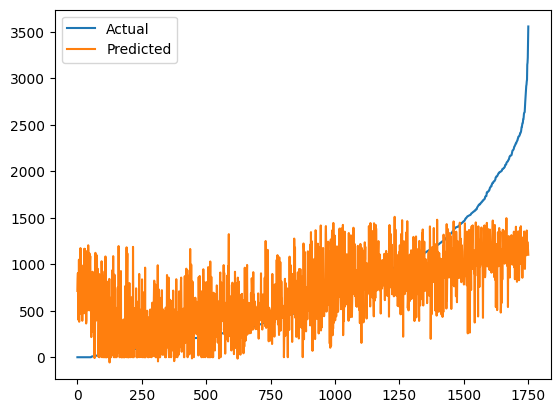

In [ ]:
best_ind = hof.items[0]

test_data.sort_values(by=['Count'], inplace=True)
test_data = test_data.reset_index(drop=True)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i]] for i in range(len(test_data))]
x = [i for i in range(len(test_data))]
y_values1 = test_data['Count'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs]
plt.plot(x, y_values1, label='Actual')
plt.plot(x, y_values2, label='Predicted')
plt.legend()
plt.show()

[6.664079225478184, 0.4581185163475491, -1.318477734390295, -1.3606332540966655, -2.1046796780725225, 3.6616626491030804, -5.8926519716776875, 4.608725528990066, -10.611705831867026, 8.761602177769475, 0.20851616758092473, 2.60835726890931, 7.26807962837511, -1.8900903717089623, -5.97635399102484, 2.276610160010599, 0.21816324354205058, 5.7724222886476, -0.6898551126653188, -8.921762735718458, 0.16739577936584932, -5.9761160009675525, -0.8639841330819393, 0.4849042951951254, -5.395043950525465, 9.548077243804357, -5.766902118526401, -1.2019012935577358, 3.4827574597287123, -3.652798707858401, -1.2615631520333754, -6.631989498408493, 4.55117664423373, -4.142557784790032, 9.865703665286365, -4.667818842446607, 2.8607301305902766, -1.1791373661936522, -2.9498601302910172, 4.957647985599753, 2.3089696547425573, -0.18453367201739704, 2.9483088668816952, 2.9201742929400796, 2.192025258216973, 1.5488342679501508, -1.9872185330632073, 1.7054361616060665, 2.1043349961852846, -1.933464176304157,

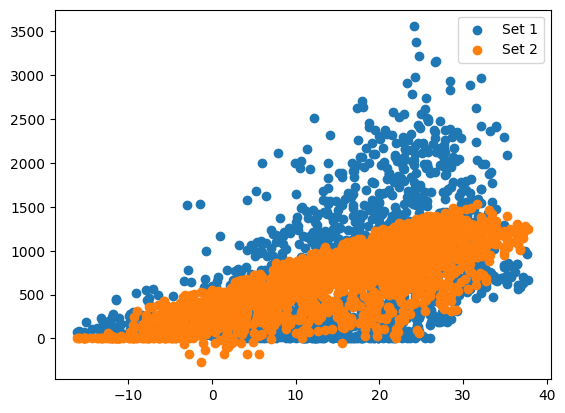

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = hof.items[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
print(toolbox.evaluate(best_ind, myNet, test_data))
myNet.setWeightsLinear(best_ind)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i]] for i in range(len(test_data))]

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([828.72854714]), array([916.27916943]), array([733.0545866]), array([347.13037602]), array([819.62543574]), array([358.83183246]), array([1084.62865926]), array([291.999865]), array([633.6027367]), array([621.97552232]), array([768.22010606]), array([553.78064089]), array([1230.57158002]), array([616.52564512]), array([693.5824046]), array([896.3030733]), array([510.64787761]), array([587.41042337]), array([707.82584498]), array([306.33322622]), array([940.8760776]), array([707.27244516]), array([925.54204276]), array([833.63685428]), array([1078.13448763]), array([623.47998313]), array([617.12816994]), array([1237.37323908]), array([667.12011158]), array([1215.13147998]), array([805.70048192]), array([452.17432082]), array([795.96905143]), array([798.0336002]), array([63.74512468]), array([108.89319486]), array([986.1127863]), array([1180.88992043]), array([755.59700396]), array([301.69522755]), array([952.20816184]), array([748.4913577]), array([1245.37729651]), array([1148.30

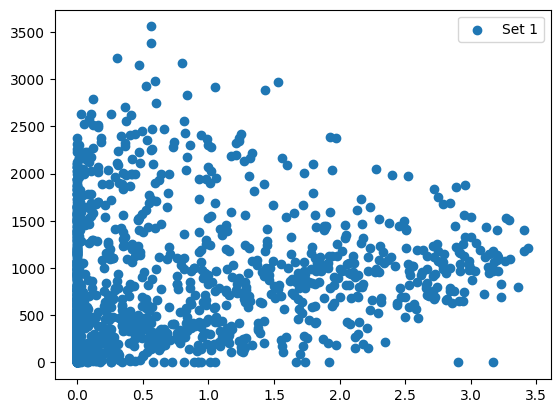

[6.664079225478184, 0.4581185163475491, -1.318477734390295, -1.3606332540966655, -2.1046796780725225, 3.6616626491030804, -5.8926519716776875, 4.608725528990066, -10.611705831867026, 8.761602177769475, 0.20851616758092473, 2.60835726890931, 7.26807962837511, -1.8900903717089623, -5.97635399102484, 2.276610160010599, 0.21816324354205058, 5.7724222886476, -0.6898551126653188, -8.921762735718458, 0.16739577936584932, -5.9761160009675525, -0.8639841330819393, 0.4849042951951254, -5.395043950525465, 9.548077243804357, -5.766902118526401, -1.2019012935577358, 3.4827574597287123, -3.652798707858401, -1.2615631520333754, -6.631989498408493, 4.55117664423373, -4.142557784790032, 9.865703665286365, -4.667818842446607, 2.8607301305902766, -1.1791373661936522, -2.9498601302910172, 4.957647985599753, 2.3089696547425573, -0.18453367201739704, 2.9483088668816952, 2.9201742929400796, 2.192025258216973, 1.5488342679501508, -1.9872185330632073, 1.7054361616060665, 2.1043349961852846, -1.933464176304157,

In [ ]:
# Assuming you have two sets of data:
x_values1 = test_data['Sunshine'].to_list()
y_values1 = test_data['Count'].to_list()

# x_values2 = test_data['Rain'].to_list()
# y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
# plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()
print(best_ind)

In [ ]:
# Assuming you have two sets of data:
x_values1 = evdata['Month'].to_list()
y_values1 = evdata['Count'].to_list()

x_values2 = evdata['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

NameError: name 'evdata' is not defined

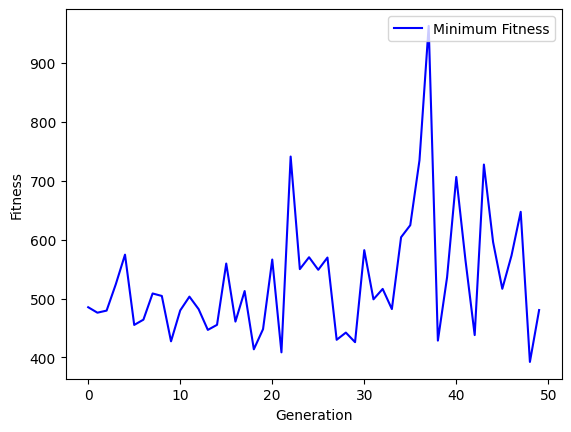

In [ ]:
## Graph fitness over generations

gen = logbook.select("gen")
fit_mins = logbook.select("min")


plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")

plt.show()